Check rates by age group:
age_group
<25      0.439
25-35    0.352
35-45    0.203
45-55    0.097
55+      0.097
Name: predicted, dtype: float64

Check rates by neighborhood:
neighborhood
Other                   0.143
Target Neighborhoods    0.163
Name: predicted, dtype: float64

Check rates by age and neighborhood:
neighborhood  Other  Target Neighborhoods
age_group                                
<25           0.427                 0.462
25-35         0.338                 0.377
35-45         0.194                 0.221
45-55         0.091                 0.108
55+           0.093                 0.104

Age disparity ratio (youngest/oldest): 4.54x


C:\Users\Daniel\AppData\Local\Temp\ipykernel_12132\1332758022.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(analysis_df.groupby('age_group')['predicted'].mean().round(3))
C:\Users\Daniel\AppData\Local\Temp\ipykernel_12132\1332758022.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(analysis_df.groupby(['age_group', 'neighborhood'])['predicted'].mean().unstack().round(3))


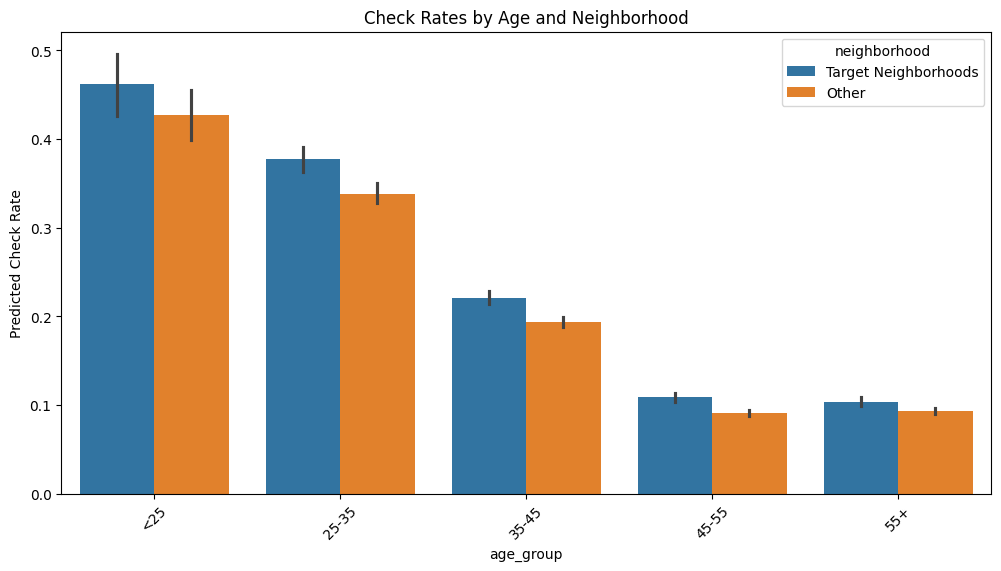

In [3]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

# Load model and data
with open('../biased_model.pkl', 'rb') as f:
   model = pickle.load(f)
   
df = pd.read_csv('../data/investigation_train_large_checked.csv')
features = [col for col in df.columns if col != 'checked']
X = df[features]

# Get predictions
predictions = model.predict(X)

# Create analysis dataframe
analysis_df = pd.DataFrame({
   'age': df['persoon_leeftijd_bij_onderzoek'],
   'neighborhood': np.where(df[['adres_recentste_wijk_prins_alexa', 
                               'adres_recentste_wijk_delfshaven',
                               'adres_recentste_wijk_feijenoord']].sum(axis=1) > 0, 
                          'Target Neighborhoods', 'Other'),
   'predicted': predictions
})

# Create age groups
analysis_df['age_group'] = pd.cut(analysis_df['age'], 
                                bins=[0, 25, 35, 45, 55, 100],
                                labels=['<25', '25-35', '35-45', '45-55', '55+'])

# Average check rates by age group
print("Check rates by age group:")
print(analysis_df.groupby('age_group')['predicted'].mean().round(3))

# Check rates by neighborhood
print("\nCheck rates by neighborhood:")
print(analysis_df.groupby('neighborhood')['predicted'].mean().round(3))

# Combined age and neighborhood
print("\nCheck rates by age and neighborhood:")
print(analysis_df.groupby(['age_group', 'neighborhood'])['predicted'].mean().unstack().round(3))

# Calculate disparities
youngest = analysis_df[analysis_df['age_group'] == '<25']['predicted'].mean()
oldest = analysis_df[analysis_df['age_group'] == '55+']['predicted'].mean()
print(f"\nAge disparity ratio (youngest/oldest): {(youngest/oldest).round(2)}x")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=analysis_df, x='age_group', y='predicted', hue='neighborhood')
plt.title('Check Rates by Age and Neighborhood')
plt.ylabel('Predicted Check Rate')
plt.xticks(rotation=45)
plt.show()

The visualization reveals clear age and geographic bias in our model. Young people (<25) experience check rates of 43.9%, over 4 times higher than those 55+ at 9.7%. Living in target neighborhoods (Prins Alexander, Delfshaven, Feijenoord) compounds this bias, with young residents facing rates up to 46.2% compared to 42.7% in other areas. This matches our engineered biases using sample weights during training.